In [1]:
from submissions.ab_submission.dataLoaders import imageDataLoader
from submissions.ab_submission.object_detector import ObjectDetector
from submissions.ab_submission import dataset

import importlib

importlib.reload(dataset)

<module 'submissions.ab_submission.dataset' from '/home/ali/git/follicles_detection/submissions/ab_submission/dataset.py'>

In [2]:
import glob
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
train_files = glob.glob("./data/train/*.jpg")
test_files = glob.glob("./data/test/*.jpg")
train_label = pd.read_csv("./data/train/labels.csv")
test_label = pd.read_csv("./data/test/labels.csv")

In [4]:
test_loader = imageDataLoader(test_files, test_label[["filename","xmin","xmax","ymin","ymax","label"]])
train_loader = imageDataLoader(train_files, train_label[["filename","xmin","xmax","ymin","ymax","label"]])
predict_loader = imageDataLoader(test_files, None)

In [5]:
import cv2
import numpy as np

In [6]:
import torch
from torch import nn
from torch.optim import Adam

In [258]:
# Dataset Generation
r = 10

X = []
Y = []
for x in train_loader.get_samples():
    new_shape = [int(x/r) for x in x[0].shape[0:2]]
    new_img = cv2.resize(x[0].astype(np.uint8), new_shape)
    new_img = (new_img-new_img.mean())/(new_img.max()-new_img.min())

    label_matrix = np.zeros(x[0].shape[0:2])

    for bbox, label in zip(x[1], x[2]):
        if label > 0:
            label_matrix[bbox[2]:bbox[3], bbox[0]:bbox[1]] = 1
    label_matrix = label_matrix.astype("int8")
    new_label_matrix = cv2.resize(label_matrix.astype(np.uint8), new_shape)

    # Generating tensor
    new_img_tensor = torch.tensor(new_img, dtype=torch.float32)
    new_img_tensor = new_img_tensor.unsqueeze(2)
    new_img_tensor = torch.moveaxis(new_img_tensor, 2, 0)
    new_img_tensor = torch.moveaxis(new_img_tensor, 3, 1)

    new_label_matrix_tensor = torch.tensor(new_label_matrix, dtype=torch.float32)
    new_label_matrix_tensor = new_label_matrix_tensor.unsqueeze(dim=2).unsqueeze(dim=2)
    new_label_matrix_tensor = torch.moveaxis(new_label_matrix_tensor, 2, 0)
    new_label_matrix_tensor = torch.moveaxis(new_label_matrix_tensor, 3, 1)

    X.append(new_img_tensor)
    Y.append(new_label_matrix_tensor)

In [353]:
simple_network = nn.Sequential(*[
    nn.Conv2d(in_channels=3, kernel_size=(5,5), out_channels=10, padding="same"),
    nn.ReLU(),
    nn.Dropout2d(0.5),
    nn.Conv2d(in_channels=10, kernel_size=(1,1), out_channels=1, padding="same"),
    nn.Sigmoid()
])

simple_network = simple_network.to("cuda:0")

loss = nn.BCELoss()
optim = Adam(simple_network.parameters())

simple_network.train()

Sequential(
  (0): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (1): ReLU()
  (2): Dropout2d(p=0.5, inplace=False)
  (3): Conv2d(10, 1, kernel_size=(1, 1), stride=(1, 1), padding=same)
  (4): Sigmoid()
)

In [354]:
n_epochs = 20

for i in range(n_epochs):
    losses = []
    if i > 0:
        print(f"Epoch {i} - mean loss : {mean_loss}")
    for x,y in zip(X,Y):

        x = x.to("cuda:0")
        y = y.to("cuda:0")

        y_hat = simple_network(x)
        y_hat = y_hat.flatten(start_dim=2,end_dim=3).squeeze(dim=1)
        y = y.flatten(start_dim=2, end_dim=3).squeeze(dim=1)
        
        weights = y*2
        loss = nn.BCELoss(weight=weights)
        n_loss = loss(y_hat, y)

        n_loss.backward()
        losses.append(n_loss.item())
        optim.step()

        optim.zero_grad
    mean_loss = np.array(losses).mean()

Epoch 1 - mean loss : 0.0924100090653218
Epoch 2 - mean loss : 0.07981516695420804
Epoch 3 - mean loss : 0.05681431901255815
Epoch 4 - mean loss : 0.03737818751612614
Epoch 5 - mean loss : 0.0289857020111883
Epoch 6 - mean loss : 0.020044185315531773
Epoch 7 - mean loss : 0.010250550876411706
Epoch 8 - mean loss : 0.010965644543516803
Epoch 9 - mean loss : 0.006363348407015517
Epoch 10 - mean loss : 0.004909751736077255
Epoch 11 - mean loss : 0.004364046397830831
Epoch 12 - mean loss : 0.004256549655539841
Epoch 13 - mean loss : 0.012573371542964455
Epoch 14 - mean loss : 0.007746655844894592
Epoch 15 - mean loss : 0.007613201507152114
Epoch 16 - mean loss : 0.0030919807112225767
Epoch 17 - mean loss : 0.004103576766843012
Epoch 18 - mean loss : 0.009055616685346319
Epoch 19 - mean loss : 0.007397187539945633


In [355]:
X_test = []
Y_test = []
for x in test_loader.get_samples():
    new_shape = [int(x/r) for x in x[0].shape[0:2]]
    new_img = cv2.resize(x[0].astype(np.uint8), new_shape)
    new_img = (new_img-new_img.mean())/(new_img.max()-new_img.min())

    label_matrix = np.zeros(x[0].shape[0:2])

    for bbox, label in zip(x[1], x[2]):
        if label > 0:
            label_matrix[bbox[2]:bbox[3], bbox[0]:bbox[1]] = 1
    label_matrix = label_matrix.astype("int8")
    new_label_matrix = cv2.resize(label_matrix.astype(np.uint8), new_shape)

    # Generating tensor
    new_img_tensor = torch.tensor(new_img, dtype=torch.float32)
    new_img_tensor = new_img_tensor.unsqueeze(2)
    new_img_tensor = torch.moveaxis(new_img_tensor, 2, 0)
    new_img_tensor = torch.moveaxis(new_img_tensor, 3, 1)

    new_label_matrix_tensor = torch.tensor(new_label_matrix, dtype=torch.float32)
    new_label_matrix_tensor = new_label_matrix_tensor.unsqueeze(dim=2).unsqueeze(dim=2)
    new_label_matrix_tensor = torch.moveaxis(new_label_matrix_tensor, 2, 0)
    new_label_matrix_tensor = torch.moveaxis(new_label_matrix_tensor, 3, 1)

    X_test.append(new_img_tensor)
    Y_test.append(new_label_matrix_tensor)

In [356]:
with torch.no_grad():
    simple_network.eval()
    x_ = X_test[4].to("cuda:0")
    y_hat = simple_network(x_)

In [357]:
test = (y_hat >= 0.5).cpu().int()[0,0,:,:]

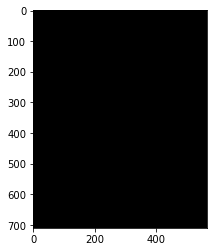

In [359]:
plt.imshow(1-test, cmap="gray")

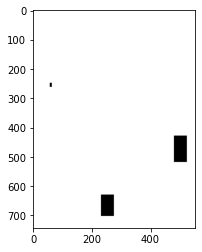

In [321]:
test2=Y_test[0].int()[0,0,:,:]
plt.imshow(1-test2, cmap="gray")